In [2110]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [2111]:
!pwd

/home/defi/Desktop/portfolio/projects/python/jupyter/notebooks


In [2112]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv') # 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv') # 0.05, 0.99, 0.5, 0.99, 0.997, 6000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.99, 0.5, 0.99, 0.997, 6000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv') # 0.01, 0.95, 1.0, 0.997, 0.995, 26000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv') # 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.01, 0.95, 1.0, 0.997, 0.995, 26000, 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlpgate.csv') # 0.25, 0.95, 0.01, 0.997, 0.999, 14000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_36rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_37rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_38rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_39rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_39rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_40rl_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_159nlp.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_43rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_46rl.csv') # 0.001, 0.99, 1.0, 0.95, 0.99, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_54rl.csv')
#df0 = pd.read_csv('/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_50rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_173nlp_refined.csv') #0.05, 0.95, 0.05, 0.99, 0.95, 8000

In [2113]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [2114]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [2115]:
df0.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,short_kdj,sma-compare,ask,bid,is_short,nlpreds,action,predicted_action,reward,refined-action
0,44.50000,44.75000,44.281457,44.135725,44.20000,1,44.30000,6.825090e+03,44.300000,44.328571,...,0,0,3.404859e+03,3.420231e+03,1,do_nothing,do_nothing,go_short,-35.430676,do_nothing
1,0.03876,0.04031,0.037357,0.035457,0.03866,1,0.03966,1.002442e+08,0.038784,0.038163,...,0,0,5.069731e+07,4.954684e+07,1,do_nothing,do_nothing,go_long,-51.032958,do_nothing
2,0.36970,0.37380,0.374378,0.380408,0.29550,1,0.34040,4.055960e+07,0.369600,0.373671,...,0,1,1.944302e+07,2.111658e+07,1,go_long,go_long,go_short,53.563565,go_long
3,8.49500,8.49500,8.566783,8.642135,8.40900,1,8.42100,7.683300e+03,8.499800,8.545286,...,0,1,3.824844e+03,3.858456e+03,1,go_long,go_long,do_nothing,11.966588,go_long
4,29.35600,29.75100,28.748782,30.812400,28.69500,0,29.34600,7.736900e+04,28.701400,28.251143,...,0,0,3.867791e+04,3.869109e+04,1,do_nothing,do_nothing,go_long,-17.428203,do_nothing


In [2116]:
#df0['refined-action'].value_counts()

In [2117]:
#df0.drop(['Unnamed:','predicted_action'], axis=1, inplace=True)

In [2118]:
#df0['nlpreds'].value_counts()

In [2119]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [2120]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [2121]:
#newdf0 = pd.DataFrame()
train_data = prep_data(df0) #if newdf0.empty else prep_data(newdf0)
#train_data = prep_data(newdf0)

In [2122]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,short_kdj,sma-compare,ask,bid,is_short,nlpreds,action,predicted_action,reward,refined-action
0,44.50000,44.75000,44.281457,44.135725,44.20000,1,44.30000,6.825090e+03,44.300000,44.328571,...,0,0,3.404859e+03,3.420231e+03,1,do_nothing,do_nothing,go_short,-35.430676,do_nothing
1,0.03876,0.04031,0.037357,0.035457,0.03866,1,0.03966,1.002442e+08,0.038784,0.038163,...,0,0,5.069731e+07,4.954684e+07,1,do_nothing,do_nothing,go_long,-51.032958,do_nothing


In [2123]:
new_cols = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'ask', 'bid', 'is_short'
        ]

In [2124]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
action_col = 'refined-action' #'imit-action' if newdf0.empty else 'refined-action'
train_data["action_num"] = train_data[f"{action_col}"].map(action_mapping)

In [2125]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [2126]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [2127]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.9, 0.95, 1.0, 0.99, 0.99, 8000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
# [0.05, 0.95, 1.0, 0.999, 0.995, 12000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.25, 0.99, 0.01, 0.997, 0.99, 8000]
# [1, 0.75, 0.05, 0.999, 0.999, 10000], [0.01, 0.85, 0.01, 0.95, 0.95, 12000], [0.01, 0.99, 1.0, 0.95, 0.99, 16000], [0.05, 0.99, 0.5, 0.99, 0.997, 6000]
# [0.25, 0.95, 0.01, 0.997, 0.999, 14000], [0.01, 0.95, 1.0, 0.997, 0.995, 26000], [0.9, 0.9, 0.005, 0.95, 0.999, 10000]
# [0.7, 0.95, 0.5, 0.999, 0.99, 16000], [0.005, 0.75, 0.1, 0.95, 0.999, 12000], [0.001, 0.75, 1.0, 0.99, 0.99, 30000]
# [0.25, 0.75, 0.01, 0.995, 0.999, 20000], [0.001, 0.99, 1.0, 0.95, 0.99, 10000], [1, 0.75, 0.005, 0.95, 0.95, 22000]
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = 0.1, 0.9, 0.99, 0.99, 0.995, 4000 #0.25, 0.75, 0.01, 0.995, 0.999, 20000 #0.9, 0.9, 0.005, 0.95, 0.999, 10000 # 0.25, 0.95, 0.01, 0.997, 0.999, 14000



In [2128]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['ask'], \
                 row['bid'], row['is_short']
                )
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('large_state_to_index.npy', state_to_index)


In [2129]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

In [2130]:

# Load the best episode transitions
best_episode_transitions = np.load("best_large_episode_transitions.npy", allow_pickle=True)

# Optionally, pre-train the Q-table using the best episode
for state, action, reward, next_state in best_episode_transitions:
    best_next_action = np.argmax(q_table[next_state])
    q_table[state, action] += alpha * (reward + gamma * q_table[next_state, best_next_action] - q_table[state, action])

# Load the previously saved Q-table and best episode transitions
best_q_table = np.load("best_large_q_table.npy")  # Load the best Q-table
best_episode_transitions = np.load("best_large_episode_transitions.npy", allow_pickle=True).tolist()  # Load best transitions'


Evaluating results per episode...:   1%|          | 23/4000 [00:00<00:17, 222.22it/s]

Episode 0/4000 - Total Reward: 2787.0924914299994, Epsilon: 0.99


Evaluating results per episode...:  11%|█         | 440/4000 [00:01<00:12, 276.74it/s]

Episode 400/4000 - Total Reward: 2821.782146219999, Epsilon: 0.99


Evaluating results per episode...:  21%|██        | 849/4000 [00:03<00:11, 283.22it/s]

Episode 800/4000 - Total Reward: 6673.750427669997, Epsilon: 0.99


Evaluating results per episode...:  31%|███       | 1233/4000 [00:04<00:09, 285.50it/s]

Episode 1200/4000 - Total Reward: 5341.282628310001, Epsilon: 0.99


Evaluating results per episode...:  41%|████      | 1639/4000 [00:05<00:08, 275.63it/s]

Episode 1600/4000 - Total Reward: 3580.3812356199987, Epsilon: 0.99


Evaluating results per episode...:  51%|█████     | 2037/4000 [00:07<00:08, 244.74it/s]

Episode 2000/4000 - Total Reward: 17471.267668980003, Epsilon: 0.99


Evaluating results per episode...:  62%|██████▏   | 2465/4000 [00:09<00:06, 254.11it/s]

Episode 2400/4000 - Total Reward: 14393.412636580037, Epsilon: 0.99


Evaluating results per episode...:  71%|███████   | 2838/4000 [00:10<00:05, 232.35it/s]

Episode 2800/4000 - Total Reward: 3383.869935739999, Epsilon: 0.99


Evaluating results per episode...:  81%|████████  | 3236/4000 [00:12<00:02, 264.82it/s]

Episode 3200/4000 - Total Reward: 18773.564733450014, Epsilon: 0.99


Evaluating results per episode...:  91%|█████████ | 3649/4000 [00:13<00:01, 255.31it/s]

Episode 3600/4000 - Total Reward: 21810.95183448995, Epsilon: 0.99


Evaluating results per episode...: 100%|██████████| 4000/4000 [00:15<00:00, 263.04it/s]


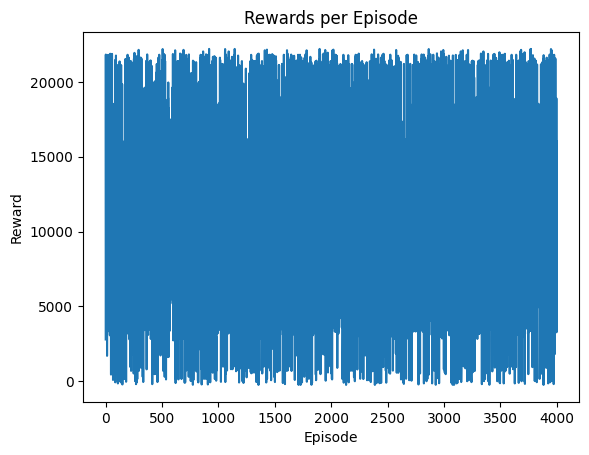

Best Episode Reward: 22202.04234111995
Best Episode Transitions: [(34, 0, 46.9070456, 35), (35, 0, 14.36017624, 36), (36, 1, 24.64068362, 37), (37, 1, 78.13437083, 38), (38, 0, 58.40008289, 39)] ...
Best Episode Hyperparameters: {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.99, 'min_epsilon': 0.99, 'decay_rate': 0.995, 'n_episodes': 4000}


In [2131]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define hyperparameters

# Initialize lists to store rewards and transitions per episode
rewards_per_episode = []
#best_episode_transitions = []
#best_q_table = None
best_total_reward = float('-inf')  # Initialize with negative infinity
best_hyperparameters = {}  # Dictionary to store hyperparameters of best episode

for episode in tqdm(range(n_episodes), desc="Evaluating results per episode..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode
    episode_transitions = []  # Store (state, action, reward, next_state) tuples for this episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        best_q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )

        total_reward += reward  # Accumulate reward
        episode_transitions.append((current_state, action, reward, next_state))
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store total reward for the current episode

    # Check if this is the best episode so far
    if total_reward > best_total_reward:
        best_total_reward = total_reward
        best_episode_transitions = episode_transitions.copy()
        best_q_table = best_q_table.copy()

        # Store the hyperparameters at the best episode
        best_hyperparameters = {
            "alpha": alpha,
            "gamma": gamma,
            "epsilon": epsilon,
            "min_epsilon": min_epsilon,
            "decay_rate": decay_rate,
            "n_episodes": n_episodes
        }

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Save the best episode's Q-table
np.save("best_large_q_table.npy", best_q_table)
# Save the best episode's transitions
np.save("best_large_episode_transitions.npy", np.array(best_episode_transitions, dtype=object))
# Plot the rewards per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()

# Print best episode results
print(f"Best Episode Reward: {best_total_reward}")
print(f"Best Episode Transitions: {best_episode_transitions[:5]} ...")  # Show first 5 transitions
print(f"Best Episode Hyperparameters: {best_hyperparameters}")

In [2165]:
def compute_action_transition_probabilities(episode_transitions_file):
    """
    Compute the action transition probability matrix from episode transitions with labeled actions.

    Parameters:
    - episode_transitions_file: str, path to the .npy file containing episode transitions.

    Returns:
    - transition_matrix: pd.DataFrame, the action transition probability matrix with labeled actions.
    """
    # Load episode transitions [(state, action, reward, next_state)]
    episode_transitions = np.load(episode_transitions_file, allow_pickle=True)

    # Extract action transitions
    action_transitions = [(t[1], episode_transitions[i + 1][1]) 
                          for i, t in enumerate(episode_transitions[:-1])]

    # Create DataFrame
    df_transitions = pd.DataFrame(action_transitions, columns=['current_action', 'next_action'])

    # Map action indices to their corresponding names
    action_names = {0: 'go_long', 1: 'go_short', 2: 'do_nothing'}
    df_transitions['current_action'] = df_transitions['current_action'].map(action_names)
    df_transitions['next_action'] = df_transitions['next_action'].map(action_names)

    # Compute transition matrix
    transition_matrix = df_transitions.groupby(['current_action', 'next_action']).size().unstack(fill_value=0)

    # Normalize to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    print("Action Transition Probability Matrix:")
    print(transition_matrix)

    return transition_matrix

# Example usage:
# transition_matrix = compute_action_transition_probabilities("best_bids_episode_transitions.npy")

In [2132]:
def load_q_table(file_path):
    return np.load(file_path, allow_pickle=True)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="large_state_to_index.npy")
loaded_qtable = load_q_table(file_path="best_large_q_table.npy")

In [2133]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                open: float, high: float, ema_26: float, ema_12: float, low: float,
                mean_grad_hist: float, close: float, volume: float, sma_25: float,
                long_jcrosk: float, short_kdj: float, sma_compare: int, is_short: int,
            ):
    state = np.array([[open, high, ema_26, ema_12, low, mean_grad_hist, close, volume, sma_25, long_jcrosk, short_kdj, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [2134]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [2135]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask', 'bid', 'is_short']].values
    action = predict_action(state, best_q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [2136]:
# Predict an entire range
def predict_range(filename: str) -> DataFrame:
    df = pd.read_csv(filename)
    df['action_num'] = train_data['action_num']
    for idx, row in df.iterrows():
        state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask', 'bid', 'is_short']].values
        action = predict_action(state, best_q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

### Change this to predict a different file

In [2137]:
#train_data = predict_range('../spreadsheets/rlhf_large_173nlp.csv')

In [2138]:
train_data['predicted_action'].value_counts()

predicted_action
go_short      465
do_nothing    389
go_long       388
Name: count, dtype: int64

In [2139]:
m = train_data[((train_data['predicted_action'] == 'go_short') & (train_data['predicted_action'] == 'do_nothing')) & (train_data['reward'] > 0)]
m['is_short'].value_counts()

Series([], Name: count, dtype: int64)

In [2140]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

None
None


In [2141]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(best_q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/1241
Current Predicted Reward: 0
Current Actual Reward: -51.032958
Processed state 100/1241
Current Predicted Reward: 191.07242583000001
Current Actual Reward: 689.93978608
Processed state 200/1241
Current Predicted Reward: 1169.64849554
Current Actual Reward: 2974.55021633
Processed state 300/1241
Current Predicted Reward: 1861.0483007900002
Current Actual Reward: 4713.566238529998
Processed state 400/1241
Current Predicted Reward: 3079.585171580001
Current Actual Reward: 7435.592408749999
Processed state 500/1241
Current Predicted Reward: 3193.48091497
Current Actual Reward: 9818.464269250007
Processed state 600/1241
Current Predicted Reward: 3484.313322129999
Current Actual Reward: 10692.231390490011
Processed state 700/1241
Current Predicted Reward: 3674.502763229999
Current Actual Reward: 13025.656922350017
Processed state 800/1241
Current Predicted Reward: 3965.1225216899984
Current Actual Reward: 14993.718664730017
Processed state 900/1241
Current Predicted Rew

In [2142]:
# Accuracy

correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(best_q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 31.16%


In [2143]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(best_q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[130 155 129]
 [131 132 151]
 [136 153 125]]


In [2144]:
def accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP/n_states

In [2145]:
print(accuracy(cm, n_states=n_states))

0.3115942028985507


In [2146]:
df0['action'].value_counts()

action
do_nothing    414
go_long       414
go_short      414
Name: count, dtype: int64

In [2147]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [2148]:
#action_reward('do_nothing', 0)

In [2149]:
dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)

go_long 0: {'counts': 312, 'total reward': 8320.49533174, 'winrate': '80.45%', 'per trade profit': 45.10735505764941, 'per trade loss': -49.2041112742623}
go_long 1: {'counts': 76, 'total reward': -3589.2761939399993, 'winrate': '1.32%', 'per trade profit': 37.32270188, 'per trade loss': -48.35465194426667}
go_short 0: {'counts': 69, 'total reward': -3575.1790166700002, 'winrate': '2.90%', 'per trade profit': 130.59773676, 'per trade loss': -57.259320749104475}
go_short 1: {'counts': 396, 'total reward': 13201.261249050001, 'winrate': '78.28%', 'per trade profit': 54.21370090429033, 'per trade loss': -41.918442224186045}
do_nothing 0: {'counts': 197, 'total reward': 3235.1666927399992, 'winrate': '79.70%', 'per trade profit': 34.44081403363057, 'per trade loss': -54.30102776350001}
do_nothing 1: {'counts': 192, 'total reward': 4176.943888970001, 'winrate': '55.73%', 'per trade profit': 76.81267004672898, 'per trade loss': -47.55308007094118}


In [2164]:
transition_matrix = compute_action_transition_probabilities("best_large_episode_transitions.npy")
print(transition_matrix)

Action Transition Probability Matrix:
next_action            0         1         2
current_action                              
0               0.324873  0.329949  0.345178
1               0.344828  0.339901  0.315271
2               0.307882  0.339901  0.352217
next_action            0         1         2
current_action                              
0               0.324873  0.329949  0.345178
1               0.344828  0.339901  0.315271
2               0.307882  0.339901  0.352217


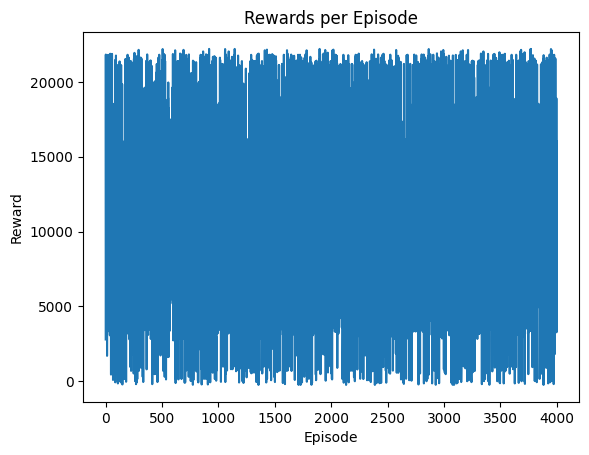

In [2150]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [2151]:
# create corrected action
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    return row['predicted_action']

def refiner_action(version: str, data: DataFrame = None) -> DataFrame:
    data['refined-action'] = data.apply(lambda x: correct_action(x), axis=1)
    # Validation: Ensure we're fixing the 751 misclassified entries
    misclassified = data[
        (data['predicted_action'] == 'go_long') & 
        (data['refined-action'] == 'go_short')
    ]
    # Add this after applying refined-action
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],  # Assuming you have ground truth column
        rownames=['refined'],
        colnames=['predicted']
    )
    print("Updated Confusion Matrix:")
    print(confusion_matrix) 
    print(f"Corrected {len(misclassified)} go_long->go_short misclassifications")
    filename = f'/home/defi/Desktop/portfolio/projects/python/jupyter/spreadsheets/rlhf_large_{version}_refined.csv'
    data.to_csv(filename, index=False)
    return data

In [2152]:
base_dir = '/home/defi/Desktop/portfolio/projects/python/pipeline_defi/'

def refine_file(version: str, file) -> DataFrame:
    filename = f'{base_dir}{file}.csv'
    print(filename)
    df = pd.read_csv(filename)
    df = df[df['reward'] > 0]
    new_data = prep_data(df) #if newdf0.empty else prep_data(newdf0.copy())
    #new_data = prep_data(df)   
    print(new_data.columns)
    new_train_data = refiner_action(version=version, data=new_data)

    #new_data = df0.copy()
    print(new_train_data.columns)

    new_train_data['nlpreds'] = new_train_data['predicted_action']
    #new_train_data['predicted_action'] = new_train_data['predicted_action']
    return new_train_data

In [2153]:
newdf0 = refine_file('99rl', 'lean_df_99rl')

/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_99rl.csv
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'action',
       'predicted_action', 'reward'],
      dtype='object')
Updated Confusion Matrix:
predicted  do_nothing  go_long  go_short
refined                                 
go_long            24       52        31
go_short           61       93        77
Corrected 93 go_long->go_short misclassifications
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'action',
       'predicted_action', 'reward', 'refined-action'],
      dtype='object')


In [2154]:
newdf0['predicted_action'].value_counts()

predicted_action
go_long       145
go_short      108
do_nothing     85
Name: count, dtype: int64

In [2155]:
newdf0['nlpreds'].value_counts()

nlpreds
go_long       145
go_short      108
do_nothing     85
Name: count, dtype: int64

In [2156]:
newdf0[newdf0['predicted_action'] == 'go_long']['reward'].cumsum().iloc[-1]

8064.39466566

In [2157]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [2158]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [2159]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")
'''


'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [2160]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [2161]:
#action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}

In [2162]:
'''
train_data = newdf0
train_data['action_num'] = train_data[f"predicted_action"].map(action_mapping)
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ntrain_data = newdf0\ntrain_data[\'action_num\'] = train_data[f"predicted_action"].map(action_mapping)\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > b